# Transmission line circuit

We consider the transmission line model used in  [AKS11]. The RLC circuit of the transmission line is shown below.

<img src="tline.png" alt="Transmission line circuit" style="width: 700px;"/>

Here, $U_{in}$ is the voltage at the sending end, and $U_{out}$ is the voltage at the receiving end.

## Model description

The pre-requisite to understand this model is any standard textbook on electrical circuits. The electrical elements law for resistors (R), inductors (L) and capaicitors (C) are studied, for instance, in [Chapter3, K15].

Let's assume that the network consists of $\eta > 2$ nodes. There are $\eta$ dynamic equations for the capacitor voltages and $\eta$ dynamic equations for the circuit currents. Therefore, the state vector can be represented as

$$
x = [U_1, U_2, \ldots, U_\eta, I_1, I_2, \ldots, I_\eta]^T,
$$
and the state dimension is $2\eta$.

### First node

When writing the equations for the voltages and currents, we should pay attention to the sign choices in the circuit, which are slighyly non-stadard ($U_1$'s positive terminal is at the bottom, etc. as indicated by the arrows).

Let $R_d$ denote the driver resistance's current.

By Kirchhoff's voltage law,

$$
U_{in} = R_d I_1 + LI_1' - U_1,
$$
therefore
$$
\boxed{I_1' = \dfrac{U_{in} + U_1}{L} - \dfrac{R_d}{L}I_1}.
$$

By Kirchhoff's current law, and if $I_{1, C}$ denotes the current through the capacitor $C$, connected to the first node,

$I_1 = I_2 + I_{C, 1}$, and $I_{C, 1} = -CU_1'$, then

$$
\boxed{U_1' = \frac{I_2 - I_1}{C}}.
$$

### Other nodes

Other node's equations are obtained in a similar fashion. For instance, for the second loop one has

$$
-U_1 = RI_2 + LI_2' - U_2 \Rightarrow I_2' = \dfrac{U_2-U_1}{L} - \frac{R}{L}I_2
$$
for the current's equation, and 
$$
I_{2, C} = I_2 - I_3,\Rightarrow U_2' = \frac{I_3 - I_2}{C}.
$$
for the voltage's equation

Generalizing for arbitrary $l = 2, \ldots, \eta - 1$ is trivial and gives:

$$
\boxed{I'_l = \dfrac{U_l - U_{l-1}}{L} - \frac{R}{L}I_l}.
$$

$$
\boxed{U'_l = \dfrac{I_{l+1} - I_l}{C}}.
$$

### Last node

The last node corresponds to the case $l = \eta$

$$
\boxed{I'_\eta = \dfrac{U_\eta - U_{\eta-1}}{L} - \frac{R}{L}I_\eta}.
$$

$$
\boxed{U'_{out} = U'_{out} = - \frac{I_{\eta}}{C}}
$$

### System of differential equations

Recall that that the stateset is $\mathbb{R}^{2\eta}$, where the state variables are $x = [U_1, U_2, \ldots, U_\eta, I_1, I_2, \ldots, I_\eta]^T$. The system can be written as a block-diagonal system of linear ODEs, 

$$
x'(t) = Ax(t) + BU_{in}(t),
$$
using the results in the previous section.

The coefficients matrix $A$ can be written as a block-diagonal matrix. There exist useful constructors in `Base.LinearAlgebra` that simplify building matrices with special shape, as in our case, such as diagonal and band matrices.

In [1]:
using MathematicalSystems, LinearAlgebra, SparseArrays

function tline(;η=3, R=1.00, Rd=10.0, L=1e-10, C=1e-13 * 4.00)
    A₁₁ = zeros(η, η)
    A₁₂ = Bidiagonal(fill(-1/C, η), fill(1/C, η-1), :U)
    A₂₁ = Bidiagonal(fill(1/L, η), fill(-1/L, η-1), :L)
    A₂₂ = Diagonal(vcat(-Rd/L, fill(-R/L, η-1)))
    A  = [A₁₁ A₁₂; A₂₁ A₂₂]
    B = sparse([η+1], [1], 1/L, 2η, 1)
    return A, B
end

tline (generic function with 1 method)

We can visualize the matrices for the case $\eta = 3$ using `ModelingToolkit`:

In [2]:
using ModelingToolkit

@variables R Rd L C
A, B = tline(η=2, R=R, Rd=Rd, L=L, C=C)
Matrix(A)

┌ Info: Recompiling stale cache file /home/mforets/.julia/compiled/v1.2/ModelingToolkit/Qmdqu.ji for ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78]
└ @ Base loading.jl:1240


4×4 Array{Expression,2}:
 Constant(0)  Constant(0)       -1 / C        1 / C
 Constant(0)  Constant(0)  Constant(0)       -1 / C
       1 / L  Constant(0)      -Rd / L  Constant(0)
      -1 / L        1 / L  Constant(0)       -R / L

In [3]:
Matrix(B)

4×1 Array{Operation,2}:
 identity(0)
 identity(0)
       1 / L
 identity(0)

If we now use the default values,

In [4]:
A, B = tline(η=2)
s = LinearControlContinuousSystem(A, B)
Matrix(A)

4×4 Array{Float64,2}:
  0.0     0.0     -2.5e12   2.5e12
  0.0     0.0      0.0     -2.5e12
  1.0e10  0.0     -1.0e11   0.0   
 -1.0e10  1.0e10   0.0     -1.0e10

In [5]:
Matrix(B)

4×1 Array{Float64,2}:
 0.0   
 0.0   
 1.0e10
 0.0   

Notice that the matrix coefficients are big, so we rescale the system in time.

Hence, it is convenient to rescale the system. Let $\alpha > 0$ be a scaling factor, and let $\tilde{x}(t) = x(\alpha t)$. By the chain rule, 

$$
\tilde{x}'(t) = \alpha x'(\alpha t) = \alpha A x(\alpha t) + \alpha B U_{in}(\alpha t) = \tilde{A} \tilde{x}(t) + \tilde{B} \tilde{U}_{in}(t),
$$
where $\tilde{A} := \alpha A$ and $\tilde{B} := \alpha B$.

In [6]:
function scale!(s::AbstractContinuousSystem, α=1.0)
    s.A .*= α
    s.B .*= α
    return s
end

scale! (generic function with 2 methods)

In [14]:
scale!(s, 1e-9);

In [15]:
Matrix(s.A)

4×4 Array{Float64,2}:
  0.0     0.0     -2.5e-6   2.5e-6
  0.0     0.0      0.0     -2.5e-6
  1.0e-8  0.0     -1.0e-7   0.0   
 -1.0e-8  1.0e-8   0.0     -1.0e-8

In [9]:
Matrix(s.B)

4×1 Array{Float64,2}:
  0.0
  0.0
 10.0
  0.0

Note that under this transformation, the time horizon has to be transformed as well, through $\tilde{T} = \alpha T$.

## Reachability settings

The transmission line parameters used in this model are displayed in the following table.

|resistance in [Ω] | driver resistance in [Ω] | Inductance in [H]| Capacitance in [F]|
|------|-----|------|-----|
|R = 1.00| Rdriver = 10.0| L = 1e−10 | C = 4e−13|

The steady state is obtained by zeroing the left-hand side of the ODE, obtaining

$$
0 = x' = Ax_\infty + Bu_0 \Rightarrow x_\infty = -A^{-1}B u_0 
$$

The initial set under consideration corresponds to the steady state for input voltages $U_{in, ss} := [-0.2, 0.2]$. Moreover, an uncertainty is added so that the initial currents are also uncertain. The set of initial states is then

$$
x(0) \in \mathcal{X}_0 := -A^{-1} B  U_{in, ss} \oplus □(0.001),
$$
where $□(ϵ)$ is the infinity-norm ball of center zero and radius $ϵ$.

The time horizon is $T = 0.7s$. For modeling, we consider the scaling parameter $\alpha = 1e-9$.

We study the step response to an input voltage $U_{in}(t)$, constant for $t \in [0, T]$ over the domain $U_{in} = [0.99, 1.01]$.

We consider the case of $\eta = 20$ nodes as in [AKS11], such that the system has $n = 40$ state variables.

In [16]:
using LazySets

η = 2 # order
n = 2η # state-space dimension
A, B = tline(η=η)

Uin_ss = Interval(-0.2, 0.2)
□(ϵ) = BallInf(zeros(n), ϵ)
X0 = -inv(Matrix(A))*B*Uin_ss ⊕ □(0.001)

Uin = Interval(0.99, 1.01)
s = ConstrainedLinearControlContinuousSystem(A, B, Universe(n), Uin)
α = 1e-9 # scaling factor
scale!(s, α);

T = 0.7 * 1e-11 # time horizon
P = InitialValueProblem(s, X0);

In [20]:
A

4×4 SparseMatrixCSC{Float64,Int64} with 8 stored entries:
  [3, 1]  =  10.0
  [4, 1]  =  -10.0
  [4, 2]  =  10.0
  [1, 3]  =  -2500.0
  [3, 3]  =  -100.0
  [1, 4]  =  2500.0
  [2, 4]  =  -2500.0
  [4, 4]  =  -10.0

In [25]:
Matrix(P.s.A)

4×4 Array{Float64,2}:
   0.0   0.0  -2500.0   2500.0
   0.0   0.0      0.0  -2500.0
  10.0   0.0   -100.0      0.0
 -10.0  10.0      0.0    -10.0

In [26]:
exp(Matrix(P.s.A))

4×4 Array{Float64,2}:
  5.51582e-8  -3.80177e-8   -4.26659e-7   4.02887e-7
 -3.80177e-8   2.55684e-8    2.34109e-7  -1.68778e-7
  1.70663e-9  -9.36436e-10   9.43845e-9  -2.86534e-8
 -1.61155e-9   6.75114e-10  -2.86534e-8   6.2911e-8 

## Results

In [53]:
using Reachability, Plots
using LazySets: LinearMap

In [54]:
sol = solve(P, Options(:T=>0.7), op=BFFPSV18(:δ=>0.001));

In [55]:
Uout = map(x -> -1.0 * project(x.rs.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.rs.t_start, x.rs.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

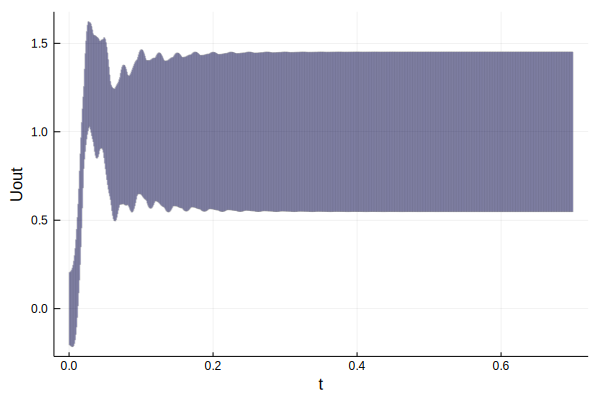

In [56]:
fig_flowpipe_BFFPSV18 = plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="Uout", alpha=.2)

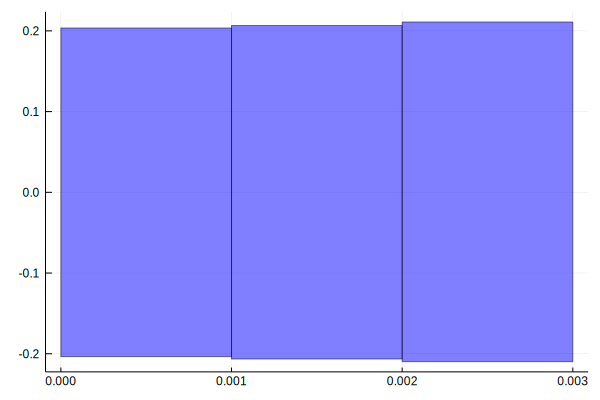

In [57]:
fig_init = plot(Uout_vs_t[1:3], color=:blue)

In the following paragraph we use another reachability algorithm, GLGM06.

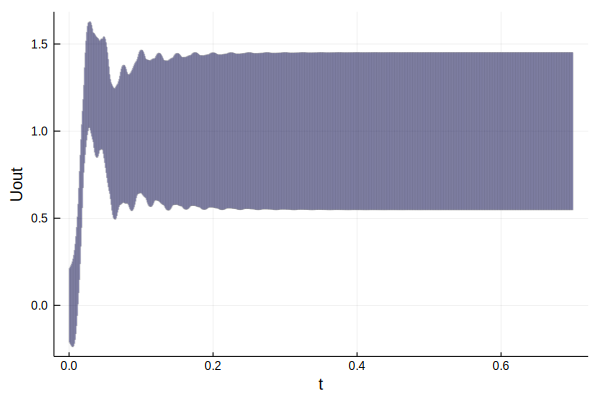

In [58]:
X0 = overapproximate(X0, Hyperrectangle)
P = InitialValueProblem(s, X0);
sol = solve(P, Options(:T=>0.7), op=GLGM06(:δ=>0.001, :max_order=>100));

Uout = map(x -> -1.0 * project(x.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.t_start, x.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

plot(Uout_vs_t[1:1:end], color=:blue, xlab="t", ylab="Uout", alpha=0.2)

## Parameter uncertainties

In [28]:
using IntervalMatrices
import IntervalArithmetic
const IA = IntervalArithmetic

IntervalArithmetic

In [29]:
Aint = IntervalMatrix([IA.Interval(x) for x in P.s.A])
Bint = IntervalMatrix([IA.Interval(x) for x in P.s.B])
Uin_int = ConstantInput(LazySets.Interval(0.99, 1.01))
sint = ConstrainedLinearControlContinuousSystem(Aint, Bint, nothing, Uin_int)
X0 = overapproximate(X0, Hyperrectangle) # for GLGM06
Pint = InitialValueProblem(sint, X0);

sol = solve(Pint, Options(:T=>0.7), op=ASB07(:δ=>0.001, :order_discretization=>15, :max_order=>100));
# uses :discretization=>"interval_matrix"
Uout = map(x -> -1.0 * project(x.X, [η], LinearMap), sol.Xk)
times = map(x -> Interval(x.t_start, x.t_end), sol.Xk)
Uout_vs_t = [Δt × u for (Δt, u) in zip(times, Uout)];

UndefVarError: UndefVarError: Options not defined

In [37]:
using LinearAlgebra

eigvals(Matrix(P.s.A))

4-element Array{Complex{Float64},1}:
 -38.72378376500386 - 91.20333272569677im
 -38.72378376500386 + 91.20333272569677im
 -16.27621623499613 - 251.7864149308556im
 -16.27621623499613 + 251.7864149308556im

In [39]:
Matrix(P.s.A)

4×4 Array{Float64,2}:
   0.0   0.0  -2500.0   2500.0
   0.0   0.0      0.0  -2500.0
  10.0   0.0   -100.0      0.0
 -10.0  10.0      0.0    -10.0

In [30]:
Aint

4×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
     [0, 0]    [0, 0]  [-2500, -2500]    [2500, 2500]
     [0, 0]    [0, 0]          [0, 0]  [-2500, -2500]
   [10, 10]    [0, 0]    [-100, -100]          [0, 0]
 [-10, -10]  [10, 10]          [0, 0]      [-10, -10]

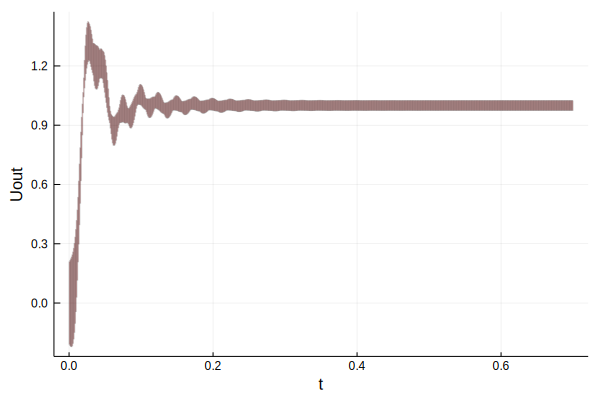

In [61]:
plot(Uout_vs_t[1:1:end], color=:red, xlab="t", ylab="Uout", alpha=.2)

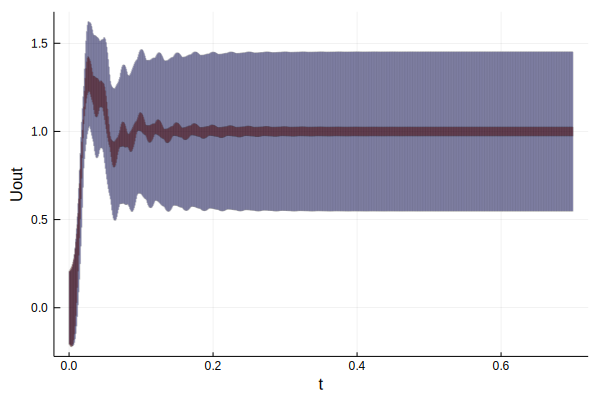

In [62]:
plot!(fig_flowpipe_BFFPSV18, Uout_vs_t[1:1:end], color=:red, xlab="t", ylab="Uout", alpha=.2)

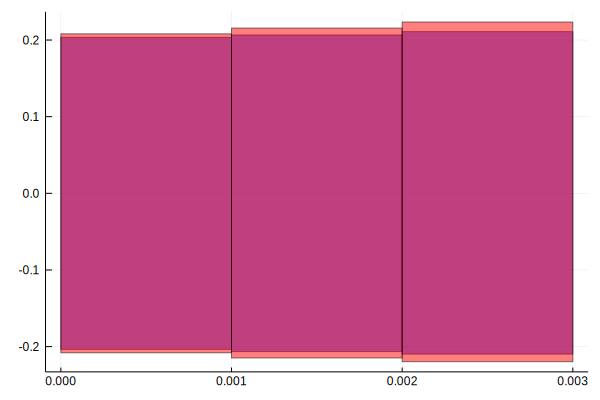

In [63]:
plot!(fig_init, Uout_vs_t[1:3], color=:red)

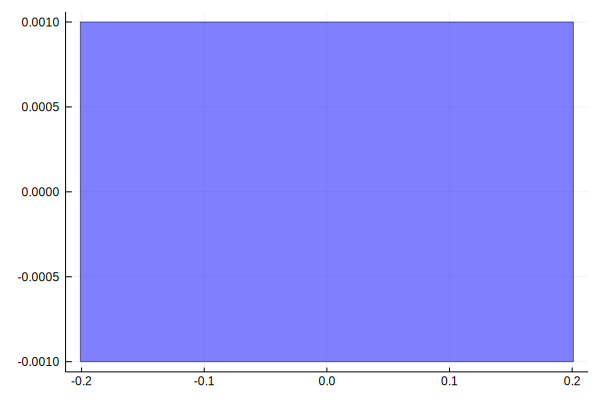

In [64]:
X0_13 = project(X0, [1, 3], LinearMap)
plot(X0_13, color=:blue)

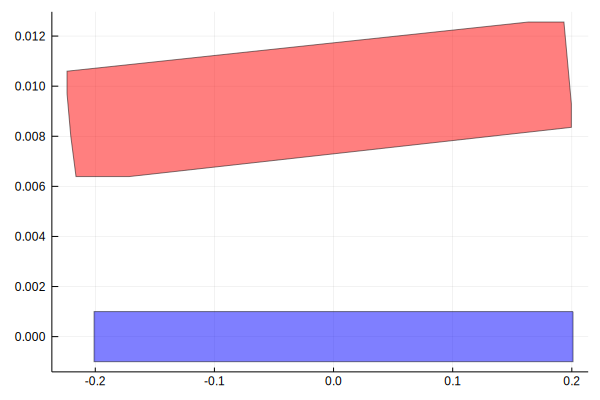

In [65]:
Xk0_13 = project(sol.Xk[1].X, [1, 3], LinearMap)
plot!(Xk0_13, color=:red)

In [66]:
X0_13 ⊆ Xk0_13

false

In [67]:
a = ρ([1.0, 0.0], X0_13)

0.201

In [68]:
b = ρ([1.0, 0.0], Xk0_13)

0.19961523469266537

In [69]:
a - b

0.00138476530733464

## References

[AKS11] Althoff, Matthias, Bruce H. Krogh, and Olaf Stursberg. [Analyzing reachability of linear dynamic systems with parametric uncertainties.](http://www.i6.in.tum.de/Main/Publications/Althoff2011b.pdf). Modeling, Design, and Simulation of Systems with Uncertainties. Springer, Berlin, Heidelberg, 2011. 69-94.

[K15] Kluever, Craig A. [Dynamic systems: modeling, simulation, and control.](https://www.wiley.com/en-us/Dynamic+Systems%3A+Modeling%2C+Simulation%2C+and+Control-p-9781118289457). John Wiley & Sons, 2015.

[GLG08] Girard, Antoine, and Colas Le Guernic. [Efficient reachability analysis for linear systems using support functions.]() IFAC Proceedings Volumes 41.2 (2008): 8966-8971.